### Hyperparameter definition

In [ ]:
# from diffusers import DiffusionPipeline

# pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-3.5-large")

# prompt = "Astronaut in a jungle, cold color palette, muted colors, detailed, 8k"
# image = pipe(prompt).images[0]


model_index.json:   0%|          | 0.00/706 [00:00<?, ?B/s]

Fetching 28 files:   0%|          | 0/28 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.53G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/588 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/740 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/19.9k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/705 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/856 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/576 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/20.6k [00:00<?, ?B/s]

(…)pytorch_model-00001-of-00002.safetensors:   0%|          | 0.00/9.99G [00:00<?, ?B/s]

(…)pytorch_model-00002-of-00002.safetensors:   0%|          | 0.00/6.31G [00:00<?, ?B/s]

(…)ion_pytorch_model.safetensors.index.json:   0%|          | 0.00/127k [00:00<?, ?B/s]

In [1]:
# First install ClearML if not already installed: pip install clearml
import clearml
from clearml import Task, Logger

# Initialize ClearML Task
task = Task.init(project_name='DreamBooth Training', task_name='dreambooth_dog', reuse_last_task_id=False)
logger = Logger.current_logger()

# Define hyperparameters with additional parameters
hyperparameters = {
    'subject_tokens': 'xon',
    'subject_prompt': 'a xon dog',
    'class_prompt': 'a dog',
    'num_prior_images': 1000,
    'learning_rate': 5e-6,
    'num_train_epochs': 100,
    'prior_batch_size': 7,
    'train_batch_size': 5,
    'use_prior_preservation': True,
    'prior_loss_weight': 0.3,
    'use_dreambooth_prompts': True
}

# Connect hyperparameters to ClearML
task.connect(hyperparameters)

# Unpack parameters directly from dict for cleaner code
subject_identifier = hyperparameters['subject_tokens']
subject_prompt = hyperparameters['subject_prompt']
class_prompt = hyperparameters['class_prompt']
num_prior_images = hyperparameters['num_prior_images']
learning_rate = hyperparameters['learning_rate']
num_train_epochs = hyperparameters['num_train_epochs']
prior_batch_size = hyperparameters['prior_batch_size']
train_batch_size = hyperparameters['train_batch_size']
use_prior_preservation = hyperparameters['use_prior_preservation']
prior_loss_weight = hyperparameters['prior_loss_weight']
use_dreambooth_prompts = hyperparameters['use_dreambooth_prompts']

ClearML Task: created new task id=5127c6025eaa42dab88caed6b3ec3e30
2025-03-24 20:52:57,071 - clearml.Task - INFO - No repository found, storing script code instead
ClearML results page: https://app.clear.ml/projects/0009581d19764aeaa42308fae5caaa27/experiments/5127c6025eaa42dab88caed6b3ec3e30/output/log


ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start


In [2]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from datasets import load_dataset, concatenate_datasets
from transformers import CLIPTextModel, CLIPTokenizer
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset

### Data loading

In [ ]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
# text_encoder = CLIPTextModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="text_encoder")
text_encoder = CLIPTextModel.from_pretrained("stabilityai/stable-diffusion-3.5-large", subfolder="text_encoder")

config.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/247M [00:00<?, ?B/s]

In [7]:
# Define image transformations
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [9]:
from torch.utils.data import Dataset
import os

class CustomDataset(Dataset):
    def __init__(self, image_dir, subject_prompt, class_prompt, tokenizer, transforms, use_dreambooth_prompts=True):
        self.image_dir = image_dir
        self.subject_prompt = subject_prompt
        self.class_prompt = class_prompt
        self.tokenizer = tokenizer
        self.image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transforms
        self.use_dreambooth_prompts = use_dreambooth_prompts

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)
        
        prompt = self.subject_prompt if self.use_dreambooth_prompts else self.class_prompt
        encoding = self.tokenizer(prompt, padding='max_length', truncation=True, max_length=self.tokenizer.model_max_length, return_tensors='pt')
        
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        
        return image, input_ids, attention_mask

In [10]:
image_dir = '../data/paper_dataset/dog'
dataset = CustomDataset(image_dir, subject_prompt, class_prompt, tokenizer, train_transforms,)

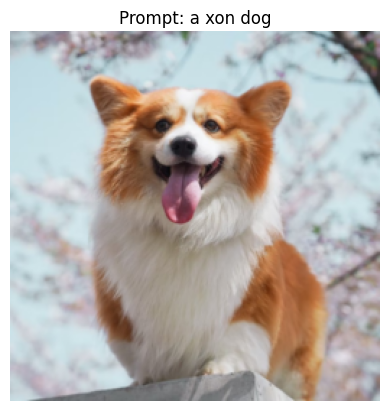

In [11]:
import matplotlib.pyplot as plt
# Function to visualize an image
def visualize_image(dataset, idx):
    image, input_ids, attention_mask = dataset[idx]
    image = image.permute(1, 2, 0)  # Change the order of dimensions for visualization
    image = image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Unnormalize the image
    image = image.numpy()
    
    plt.imshow(image)
    plt.title(f"Prompt: {dataset.subject_prompt if dataset.use_dreambooth_prompts else dataset.class_prompt}")
    plt.axis('off')
    plt.show()

# Visualize the first image in the dataset
visualize_image(dataset, 0)

In [12]:
def collate_fn(examples):
    pixel_values = torch.stack([example[0] for example in examples])
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()
    input_ids = torch.stack([example[1] for example in examples])
    attention_mask = torch.stack([example[2] for example in examples])
    return {"pixel_values": pixel_values, "input_ids": input_ids, "attention_mask": attention_mask}

In [13]:
train_batch_size = 5
train_dataloader = DataLoader(
    dataset,
    shuffle=True,
    collate_fn=collate_fn,
    batch_size=train_batch_size,
)

### Load the diffusion model for tuning

In [14]:
from diffusers import AutoencoderKL, DDPMScheduler, UNet2DConditionModel, StableDiffusionPipeline
from diffusers.optimization import get_scheduler

In [15]:
# pretrained_model_name_or_path = "CompVis/stable-diffusion-v1-4"
pretrained_model_name_or_path = "stabilityai/stable-diffusion-3.5-large"
revision = None
variant = None

In [16]:
noise_scheduler = DDPMScheduler.from_pretrained(pretrained_model_name_or_path, subfolder="scheduler")
vae = AutoencoderKL.from_pretrained(pretrained_model_name_or_path, subfolder="vae", revision=revision, variant=variant)
unet = UNet2DConditionModel.from_pretrained(pretrained_model_name_or_path, subfolder="unet", revision=revision, variant=variant)

scheduler_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/809 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

OSError: stabilityai/stable-diffusion-3.5-large does not appear to have a file named config.json.

In [13]:
import torch
import subprocess

def get_free_gpu():
    result = subprocess.check_output(
        ['nvidia-smi', '--query-gpu=memory.free', '--format=csv,nounits,noheader']
    )
    free_memory = [int(x) for x in result.decode('utf-8').strip().split('\n')]
    return free_memory.index(max(free_memory))

if torch.cuda.is_available() and torch.cuda.device_count() > 1:
    free_gpu = get_free_gpu()
    device = torch.device(f"cuda:{free_gpu}")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

weight_dtype = torch.float32

unet.to(device, dtype=weight_dtype)
vae.to(device, dtype=weight_dtype)
text_encoder.to(device, dtype=weight_dtype)

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), ep

### Set Up Prior Preservation Mechanism

In [14]:
use_prior_preservation = True
prior_loss_weight = 1.0  # lambda in the paper

In [15]:
# import matplotlib.pyplot as plt
# import torch

# if use_prior_preservation:
    
#     # Create a frozen copy of the original UNet for generating prior samples.
#     unet_pretrained = UNet2DConditionModel.from_pretrained(pretrained_model_name_or_path, 
#                                                            subfolder="unet", revision=revision, variant=variant)
#     unet_pretrained.to(device, dtype=weight_dtype)
#     unet_pretrained.eval()
    
#     # Build a separate pipeline using the frozen UNet.
#     pipeline_pretrained = StableDiffusionPipeline(
#         vae=vae,
#         text_encoder=text_encoder,
#         tokenizer=tokenizer,
#         unet=unet_pretrained,
#         scheduler=noise_scheduler,
#         safety_checker=None,
#         feature_extractor=None,
#     ).to(device)
    
#     # Pre-generate a small set of prior samples.
#     num_prior_images = num_prior_images
#     batch_size = 64
#     prior_latents_list = []
#     generated_images = []
#     print("Generating prior preservation latents...")
#     total_generated = 0
#     prior_latents_list = []
#     generated_images = []
    
#     while total_generated < num_prior_images:
#         current_batch_size = min(batch_size, num_prior_images - total_generated)
#         print(f"Generating images {total_generated} to {total_generated + current_batch_size - 1}")
#         with torch.no_grad(), torch.autocast("cuda"):
#             output = pipeline_pretrained([class_prompt] * current_batch_size, num_inference_steps=50, guidance_scale=7.5)
        
#         for j in range(current_batch_size):
#             gen_image = output.images[j].convert("RGB")
            
#             if total_generated + j < 5:
#                 generated_images.append(gen_image)
            
#             gen_image_tensor = train_transforms(gen_image).unsqueeze(0).to(device, dtype=weight_dtype)
#             with torch.no_grad():
#                 latent = vae.encode(gen_image_tensor).latent_dist.sample() * vae.config.scaling_factor
#             prior_latents_list.append(latent)
        
#         total_generated += current_batch_size

In [16]:
# # Prepare prior prompt embeddings 
# prior_inputs = tokenizer(class_prompt, return_tensors="pt", max_length=tokenizer.model_max_length,
#                             padding="max_length", truncation=True)
# prior_input_ids = prior_inputs["input_ids"].to(device)
# prior_attention_mask = prior_inputs["attention_mask"].to(device)
# with torch.no_grad():
#     prior_embeddings = text_encoder(input_ids=prior_input_ids, attention_mask=prior_attention_mask).last_hidden_state

In [17]:
# import torch
# prior_latents_tensor = torch.cat(prior_latents_list, dim=0)
# torch.save(prior_latents_tensor, '../data/prior_imgs/dog/prior_latents_tensor.pt')
# torch.save(prior_embeddings, '../data/prior_imgs/dog/prior_embeddings.pt')
# torch.save(prior_attention_mask, '../data/prior_imgs/dog/prior_attention_mask.pt')

### Set Up Training Hyperparameters & Optimizer

In [18]:
optimizer = torch.optim.AdamW(
    list(unet.parameters()) + list(vae.parameters()) + list(text_encoder.parameters()),
    lr=learning_rate,
    betas=(0.9, 0.999),
    weight_decay=1e-2,
    eps=1e-08,
)

In [19]:
# Use total steps based on dataset size (using custom_dataset length)
num_training_steps = num_train_epochs * len(dataset) // train_batch_size
lr_scheduler = get_scheduler(
    "constant",
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=num_training_steps,
)

### Set up the prior_dataloader

In [20]:
# Load the tensor from the file
prior_latents_tensor = torch.load('../data/prior_imgs/dog/prior_latents_tensor_v2.pt')
prior_embeddings = torch.load('../data/prior_imgs/dog/prior_embeddings.pt')
prior_attention_mask = torch.load('../data/prior_imgs/dog/prior_attention_mask.pt')

2025-03-24 20:46:59,541 - clearml.model - INFO - Selected model id: 9920ad23b8784fa29a2d118d89c25826
2025-03-24 20:47:03,191 - clearml.model - INFO - Selected model id: 19ad8b4f86934a839db4e47652421e5c
2025-03-24 20:47:06,907 - clearml.model - INFO - Selected model id: 375dce18e21642a286fafff59e1eeaf1


In [21]:
prior_embeddings.shape

torch.Size([1, 77, 768])

In [22]:
prior_latents_tensor.shape

torch.Size([1024, 4, 32, 32])

In [23]:
prior_attention_mask.shape

torch.Size([1, 77])

In [24]:
prior_dataset = TensorDataset(prior_latents_tensor)
prior_dataloader = DataLoader(prior_dataset, batch_size=prior_batch_size, shuffle=True)

### Model tuning

In [25]:
from diffusers import StableDiffusionPipeline

pipeline = StableDiffusionPipeline(
    vae=vae,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    unet=unet,
    scheduler=noise_scheduler,
    safety_checker=None,
    feature_extractor=None,
)
pipeline = pipeline.to(device)

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [26]:
# Training Loop with Dual (Subject + Prior) Losses
for epoch in tqdm(range(num_train_epochs), desc="Epochs"):
    unet.train()
    epoch_losses = []

    prior_iter = iter(prior_dataloader)

    for index, batch in enumerate(tqdm(train_dataloader, desc="Batches", leave=False)):
        # Move subject batch to device.
        pixel_values = batch["pixel_values"].to(dtype=weight_dtype, device=device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        # Convert subject images to latent space.
        latents = vae.encode(pixel_values).latent_dist.sample() * vae.config.scaling_factor

        # Sample noise and timesteps for subject images.
        noise = torch.randn_like(latents, device=device)
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, 
                                  (latents.shape[0],), device=device).long()
        noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

        # Get text embeddings from subject prompts.
        outputs = text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state

        # Predict noise residual for subject branch.
        model_pred = unet(noisy_latents, timesteps, encoder_hidden_states=embeddings,
                          encoder_attention_mask=attention_mask, return_dict=False)[0]
        loss_subject = F.mse_loss(model_pred.float(), noise.float(), reduction="mean")

        # ----- Prior Preservation Loss -----
        if use_prior_preservation:
            
            try:
                prior_batch = next(prior_iter)[0].to(device)
            except StopIteration:
                prior_iter = iter(prior_dataloader)
                prior_batch = next(prior_iter)[0].to(device)


            # For the prior branch, sample noise and timesteps.
            noise_prior = torch.randn_like(prior_batch, device=device)
            t_prior = torch.randint(0, noise_scheduler.config.num_train_timesteps, 
                                      (prior_batch.shape[0],), device=device).long()
            noisy_prior_latents = noise_scheduler.add_noise(prior_batch, noise_prior, t_prior)

            # Expand prior embeddings to match batch size.
            prior_embeddings_expanded = prior_embeddings.expand(noisy_prior_latents.shape[0], -1, -1)
            prior_attention_mask_expanded = prior_attention_mask.expand(noisy_prior_latents.shape[0], -1)

            # Predict noise residual for prior branch.
            model_pred_prior = unet(noisy_prior_latents, t_prior, encoder_hidden_states=prior_embeddings_expanded,
                                    encoder_attention_mask=prior_attention_mask_expanded, return_dict=False)[0]
            loss_prior = F.mse_loss(model_pred_prior.float(), noise_prior.float(), reduction="mean")
        
        else:
            loss_prior = 0.0

        # Total loss is the sum of subject loss and weighted prior loss.
        loss = loss_subject + prior_loss_weight * loss_prior

        optimizer.zero_grad()  
        loss.backward()  
        optimizer.step()  
        lr_scheduler.step() 

        epoch_losses.append(loss.item())

    avg_loss = sum(epoch_losses) / len(epoch_losses)
    
    # Log metrics
    logger.report_scalar(
        title="Training Metrics", 
        series="Loss", 
        value=avg_loss, 
        iteration=epoch
    )
    logger.report_scalar(
        title="Training Metrics",
        series="Learning Rate",
        value=lr_scheduler.get_last_lr()[0],
        iteration=epoch
    )
    
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch + 1}/{num_train_epochs}, Loss: {avg_loss:.4f}")
    # Periodic image generation and logging
    if epoch % 100 == 0:
        with torch.no_grad():
            test_image = pipeline(subject_prompt, num_inference_steps=100).images[0]
            logger.report_image(
                title="Sample Outputs",
                series=f"Epoch {epoch}",
                image=test_image,
                iteration=epoch
            )

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Loss: 0.7871


  0%|          | 0/100 [00:00<?, ?it/s]

Epochs: 100%|██████████| 100/100 [01:00<00:00,  1.65it/s]


### Inference: Generate Images using the Fine-Tuned Model

In [27]:
# from diffusers import StableDiffusionPipeline

# pipeline = StableDiffusionPipeline(
#     vae=vae,
#     text_encoder=text_encoder,
#     tokenizer=tokenizer,
#     unet=unet,
#     scheduler=noise_scheduler,
#     safety_checker=None,
#     feature_extractor=None,
# )
# pipeline = pipeline.to(device)

### Check only the subject_prompt without additional stylization

In [28]:
# Final image logging
prompt = subject_prompt
with torch.autocast(device.type):
    images = pipeline(prompt, num_inference_steps=100, guidance_scale=7.5).images

for idx, img in enumerate(images):
    logger.report_image(
        title="Final Outputs",
        series=f"Image {idx}",
        image=img,
        iteration=num_train_epochs
    )

  0%|          | 0/100 [00:00<?, ?it/s]

In [29]:
task.close()

In [30]:
subject_prompt

'a xon dog'

  0%|          | 0/100 [00:00<?, ?it/s]

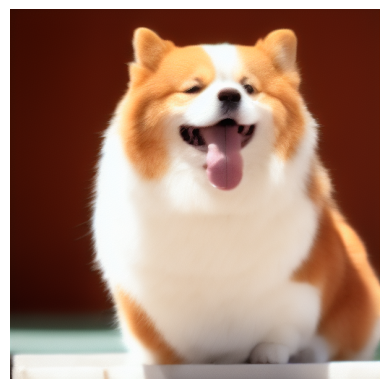

In [31]:
prompt = subject_prompt
with torch.autocast(device.type):
    images = pipeline(prompt, num_inference_steps=100, guidance_scale=7.5).images

for idx, img in enumerate(images):
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    # img.save(f"target_generated_image_{idx}.png")

### Check the subject_prompt with additional stylization

In [32]:
prompt = "sad " + subject_prompt

In [33]:
prompt

'sad a xon dog'

  0%|          | 0/100 [00:00<?, ?it/s]

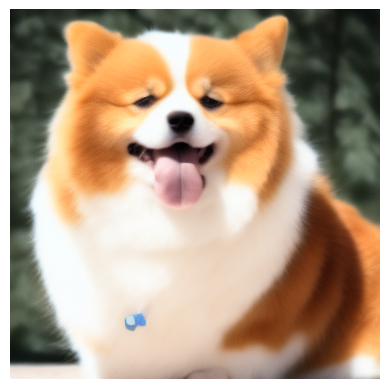

In [34]:
with torch.autocast(device.type):
    images = pipeline(prompt, num_inference_steps=100, guidance_scale=7.5).images

for idx, img in enumerate(images):
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    # img.save(f"styled_generated_image_{0}.png")


In [44]:
prompt = subject_prompt + " in astronaut costume against moon and stars. The xon dog stands proudly on the rocky lunar surface, with its paw slightly raised as if exploring."

In [45]:
# prompt = subject_prompt + " in astronaut costume xon dog against moon and stars. The xon dog stands proudly xon dog on the rocky lunar surface, with its paw xon slightly raised as if xon dog exploring."

In [46]:
prompt

'a xon dog in astronaut costume against moon and stars. The xon dog stands proudly on the rocky lunar surface, with its paw slightly raised as if exploring.'

  0%|          | 0/100 [00:00<?, ?it/s]

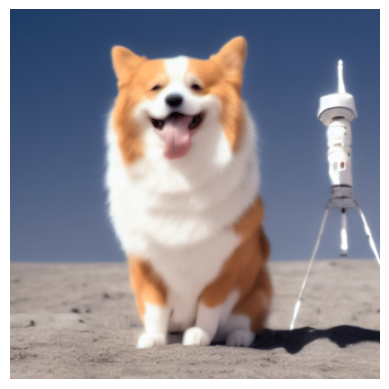

In [49]:
with torch.autocast(device.type):
    images = pipeline(prompt, num_inference_steps=100, guidance_scale=7.5).images

for idx, img in enumerate(images):
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    # img.save(f"styled_generated_image_{1}.png")


In [50]:
prompt = subject_prompt + " in cool sunglasses sitting in the sport car, smillings and have good time"

In [51]:
prompt 

'a xon dog in cool sunglasses sitting in the sport car, smillings and have good time'

  0%|          | 0/100 [00:00<?, ?it/s]

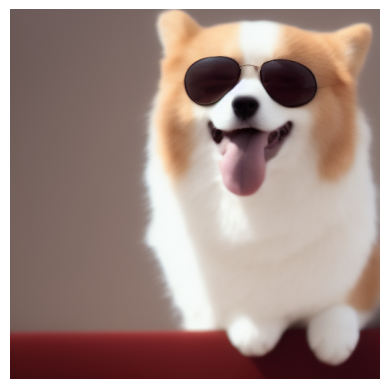

In [53]:
with torch.autocast(device.type):
    images = pipeline(prompt, num_inference_steps=100, guidance_scale=4.5).images

for idx, img in enumerate(images):
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    # img.save(f"styled_generated_image_{2}.png")
